In [1]:
# Import functions needed for this notebook
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial
from statsmodels.discrete.discrete_model import NegativeBinomial as CountNB
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Load the dataset
df = pd.read_excel("thesis_dataset.xlsx")
df.head()

,player_name,highest_ranking,country,mother_occupation,father_occupation,sibling_info,sibling_player,titles_won,association,year_turned_pro,father_occupation_std,mother_occupation_std,father_ISEI,mother_ISEI,family_ISEI
0,Roger Federer,1,Switzerland,employee at pharmaceutical firm,executive at pharmaceutical firm,True,False,103,ATP,1998,Managing directors and chief executives,Pharmaceutical technicians and assistants,70,40,55
1,Taylor Fritz,4,USA,professional tennis player,professional tennis player,True,False,8,ATP,2015,Athletes and sports players,Athletes and sports players,46,46,46
2,Novak Djokovic,1,Serbia,entrepreneur,professional skier,True,True,99,ATP,2003,Athletes and sports players,Managing directors and chief executives,46,70,58
3,Jessica Pegula,3,USA,CEO,business owner,True,False,8,WTA,2009,Managing directors and chief executives,Managing directors and chief executives,70,70,70
4,Grigor Dimitrov,3,Bulgaria,volleyball player,tennis coach,False,False,9,ATP,2008,Athletes and sports players,Athletes and sports players,46,46,46


In [3]:
# Convert boolean columns to integers
df['sibling_info'] = df['sibling_info'].astype(int)
df['sibling_player'] = df['sibling_player'].astype(int)

df.head()

,player_name,highest_ranking,country,mother_occupation,father_occupation,sibling_info,sibling_player,titles_won,association,year_turned_pro,father_occupation_std,mother_occupation_std,father_ISEI,mother_ISEI,family_ISEI
0,Roger Federer,1,Switzerland,employee at pharmaceutical firm,executive at pharmaceutical firm,1,0,103,ATP,1998,Managing directors and chief executives,Pharmaceutical technicians and assistants,70,40,55
1,Taylor Fritz,4,USA,professional tennis player,professional tennis player,1,0,8,ATP,2015,Athletes and sports players,Athletes and sports players,46,46,46
2,Novak Djokovic,1,Serbia,entrepreneur,professional skier,1,1,99,ATP,2003,Athletes and sports players,Managing directors and chief executives,46,70,58
3,Jessica Pegula,3,USA,CEO,business owner,1,0,8,WTA,2009,Managing directors and chief executives,Managing directors and chief executives,70,70,70
4,Grigor Dimitrov,3,Bulgaria,volleyball player,tennis coach,0,0,9,ATP,2008,Athletes and sports players,Athletes and sports players,46,46,46


In [4]:
# Create the association dummy (ATP baseline, keep WTA)
df['association_WTA'] = (df['association'] == 'WTA').astype(int)

In [5]:
# Get the total number of distinct countries from the `country` column
distinct_countries = df['country'].nunique()
print(f"Total distinct countries: {distinct_countries}")

Total distinct countries: 29


In [6]:
# Get the top 5 countries by the number of players
top_countries = df['country'].value_counts().head(5).index.tolist()
print("Top 5 countries by number of players: ", top_countries)

Top 5 countries by number of players:  ['USA', 'Russia', 'Australia', 'France', 'Spain']


In [7]:
# Dynamically create top-5 country dummies
for c in top_countries:
    df[f'country_{c.replace(" ","_")}'] = (df['country']==c).astype(int)

### Model 1: Titles ~ Family ISEI, Sibling Info, Sibling Player, Association Dummies, Country Dummies

In [8]:
# Prepare predictors for regression
predictors = ['family_ISEI','sibling_info','sibling_player',
              'association_WTA'] + [f'country_{c.replace(" ","_")}' for c in top_countries]

In [9]:
# Prepare regression matrices
X = sm.add_constant(df[predictors])
Y = df['titles_won']

X.head()

,const,family_ISEI,sibling_info,sibling_player,association_WTA,country_USA,country_Russia,country_Australia,country_France,country_Spain
0,1.0,55,1,0,0,0,0,0,0,0
1,1.0,46,1,0,0,1,0,0,0,0
2,1.0,58,1,1,0,0,0,0,0,0
3,1.0,70,1,0,1,1,0,0,0,0
4,1.0,46,0,0,0,0,0,0,0,0


In [10]:
# Fit the OLS model
model_OLS = sm.OLS(Y, X).fit()

In [11]:
# Print the summary of the model
print(model_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:             titles_won   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     1.425
Date:                Thu, 05 Jun 2025   Prob (F-statistic):              0.189
Time:                        12:16:45   Log-Likelihood:                -494.09
No. Observations:                 100   AIC:                             1008.
Df Residuals:                      90   BIC:                             1034.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                72.8744     20.31

In [12]:
# Fit the model with robust standard errors
model_OLS_robust = sm.OLS(Y, X).fit(cov_type='HC3')

# Print the summary of the robust model
print(model_OLS_robust.summary())

                            OLS Regression Results                            
Dep. Variable:             titles_won   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     1.729
Date:                Thu, 05 Jun 2025   Prob (F-statistic):             0.0939
Time:                        12:16:45   Log-Likelihood:                -494.09
No. Observations:                 100   AIC:                             1008.
Df Residuals:                      90   BIC:                             1034.
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                72.8744     21.08

In [13]:
# Poisson regression model
model_Poisson = sm.GLM(Y, X, family=sm.families.Poisson()).fit()

# Print the summary of the Poisson model
print(model_Poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             titles_won   No. Observations:                  100
Model:                            GLM   Df Residuals:                       90
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1614.9
Date:                Thu, 05 Jun 2025   Deviance:                       2777.9
Time:                        12:16:45   Pearson chi2:                 3.28e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9967
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.7642      0.10

In [14]:
# Fit Negative Binomial regression model
model_NegBin = sm.GLM(Y, X, family=NegativeBinomial()).fit()

# Print the summary of the Negative Binomial model
print(model_NegBin.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             titles_won   No. Observations:                  100
Model:                            GLM   Df Residuals:                       90
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -428.77
Date:                Thu, 05 Jun 2025   Deviance:                       112.81
Time:                        12:16:45   Pearson chi2:                     110.
No. Iterations:                    14   Pseudo R-squ. (CS):             0.1558
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.4854      0.57

c:\Users\peta_\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [15]:
# Check empirical dispersion from Negative Binomial model
dispersion = model_NegBin.deviance / model_NegBin.df_resid
print(f"Empirical Dispersion: {dispersion:.2f}")

Empirical Dispersion: 1.25


In [16]:
# Calculate the "true" dispersion parameter
nb2 = CountNB(Y, X).fit(disp=False, maxiter=100, method='newton')

print("Converged:", nb2.mle_retvals['converged'])
print("Alpha estimate:", nb2.params['alpha'])

Converged: True
Alpha estimate: 1.0054862332085932


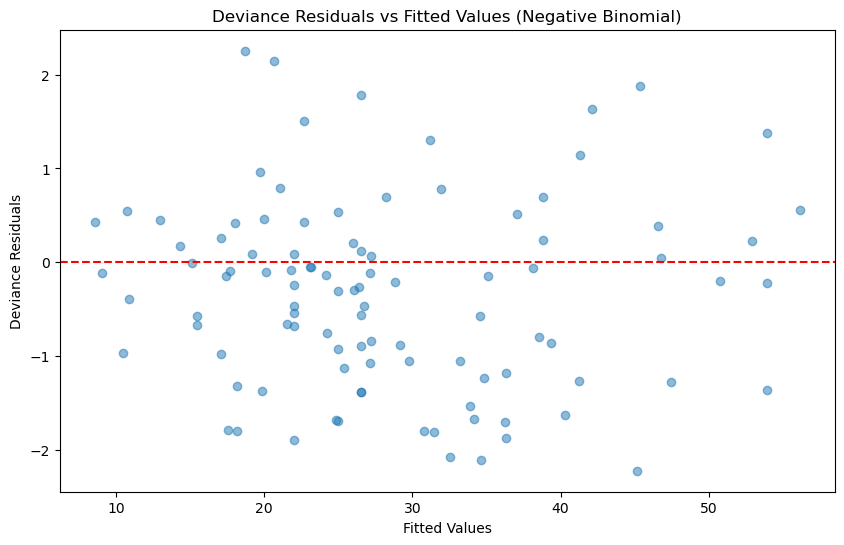

In [17]:
# Extract deviance residuals and fitted values
deviance_residuals = model_NegBin.resid_deviance
fitted_values = model_NegBin.fittedvalues

# Plot residuals vs fitted values
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, deviance_residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Deviance Residuals vs Fitted Values (Negative Binomial)')
plt.xlabel('Fitted Values')
plt.ylabel('Deviance Residuals')
plt.show()

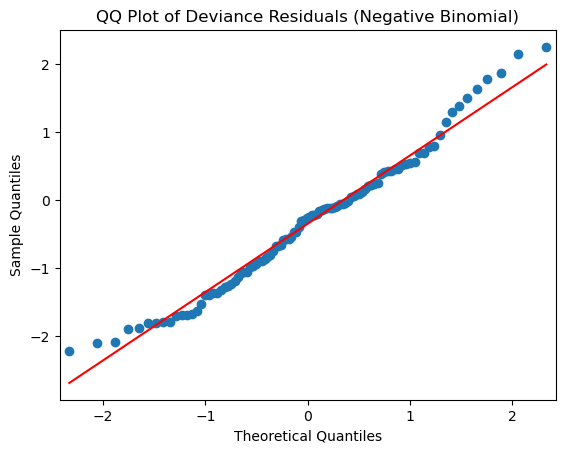

In [18]:
# QQ plot for deviance residuals
sm.qqplot(deviance_residuals, line='s')
plt.title('QQ Plot of Deviance Residuals (Negative Binomial)')
plt.show()

In [19]:
# Print out the AIC and BIC for the Poisson and NB models
print(f"Poisson Model AIC: {model_Poisson.aic}, BIC: {model_Poisson.bic}")
print(f"Negative Binomial Model AIC: {model_NegBin.aic}, BIC: {model_NegBin.bic}")

Poisson Model AIC: 3249.721635290056, BIC: 2363.429379584249
Negative Binomial Model AIC: 877.5466538107418, BIC: -301.65609922639396


c:\Users\peta_\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


In [20]:
# Build the matrix for VIF (no constant needed):
X_vif = df[predictors]

# Compute VIFs:
vif_data = pd.DataFrame({
    'Variable': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i)
            for i in range(X_vif.shape[1])]
})

print(vif_data)

            Variable        VIF
0        family_ISEI   9.035844
1       sibling_info  10.660270
2     sibling_player   2.532385
3    association_WTA   1.812528
4        country_USA   1.579292
5     country_Russia   1.135432
6  country_Australia   1.153745
7     country_France   1.162861
8      country_Spain   1.127078


### Model 2: Titles ~ Family ISEI, Sibling Info, Association Dummies, Country Dummies

In [21]:
# Define predictors for Model 2
predictors2 = ['family_ISEI', 'sibling_info', 'association_WTA'] + [f'country_{c.replace(" ", "_")}' for c in top_countries]

# Check multicollinearity using Variance Inflation Factor (VIF)
X2_vif = df[predictors2]
vif_data2 = pd.DataFrame({
    'Variable': X2_vif.columns,
    'VIF': [variance_inflation_factor(X2_vif.values, i)
            for i in range(X2_vif.shape[1])]
})
print("VIF after dropping sibling_player:\n", vif_data2)

VIF after dropping sibling_player:
             Variable       VIF
0        family_ISEI  9.019623
1       sibling_info  8.710310
2    association_WTA  1.797047
3        country_USA  1.563024
4     country_Russia  1.130389
5  country_Australia  1.135650
6     country_France  1.125239
7      country_Spain  1.112190


In [22]:
# Prepare regression matrices for Model 2
Y2 = df['titles_won']
X2 = sm.add_constant(df[predictors2])

# Fit Negative Binomial regression model for Model 2
model_NegBin2 = sm.GLM(Y2, X2, family=NegativeBinomial()).fit()

# Print the summary of the Negative Binomial model for Model 2
print(model_NegBin2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             titles_won   No. Observations:                  100
Model:                            GLM   Df Residuals:                       91
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -428.81
Date:                Thu, 05 Jun 2025   Deviance:                       112.87
Time:                        12:16:46   Pearson chi2:                     111.
No. Iterations:                    14   Pseudo R-squ. (CS):             0.1552
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.4727      0.57

c:\Users\peta_\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [23]:
# Check empirical dispersion from Negative Binomial model 2
dispersion2 = model_NegBin2.deviance / model_NegBin2.df_resid
print(f"Empirical Dispersion: {dispersion2:.2f}")

Empirical Dispersion: 1.24


In [24]:
# Calculate the "true" dispersion parameter for Model 2
nb2 = CountNB(Y2, X2).fit(disp=False, maxiter=100, method='newton')

print("Converged:", nb2.mle_retvals['converged'])
print("Alpha estimate:", nb2.params['alpha'])

Converged: True
Alpha estimate: 1.0060755977511875


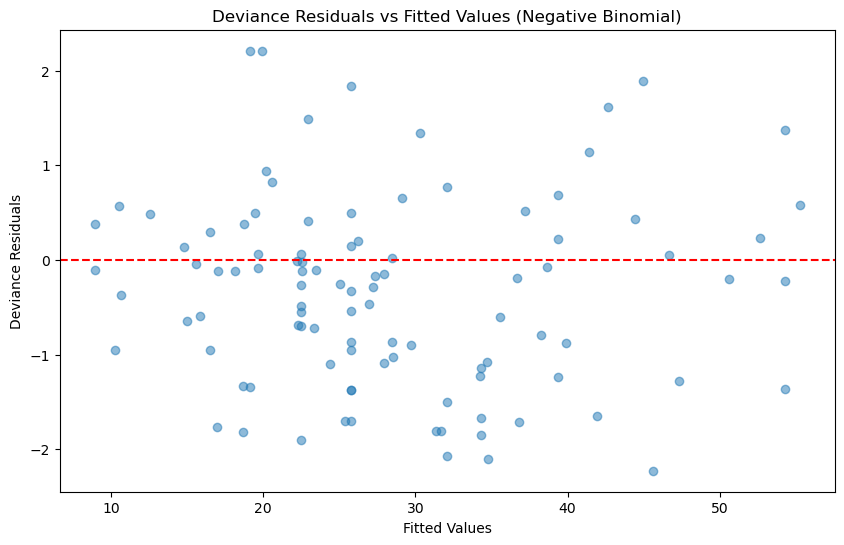

In [25]:
# Extract deviance residuals and fitted values
deviance_residuals2 = model_NegBin2.resid_deviance
fitted_values2 = model_NegBin2.fittedvalues

# Plot residuals vs fitted values
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values2, deviance_residuals2, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Deviance Residuals vs Fitted Values (Negative Binomial)')
plt.xlabel('Fitted Values')
plt.ylabel('Deviance Residuals')
plt.show()

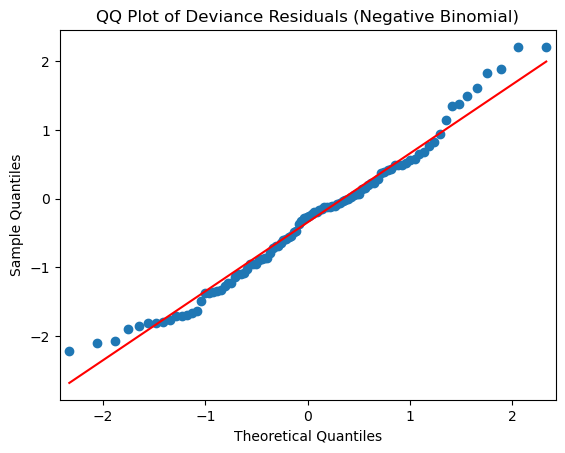

In [26]:
# QQ plot for deviance residuals
sm.qqplot(deviance_residuals2, line='s')
plt.title('QQ Plot of Deviance Residuals (Negative Binomial)')
plt.show()

In [27]:
# Poisson regression model 2
model_Poisson2 = sm.GLM(Y2, X2, family=sm.families.Poisson()).fit()

# Print the summary of the Poisson model
print(model_Poisson2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             titles_won   No. Observations:                  100
Model:                            GLM   Df Residuals:                       91
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1616.3
Date:                Thu, 05 Jun 2025   Deviance:                       2780.8
Time:                        12:16:46   Pearson chi2:                 3.31e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9966
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.7443      0.10

In [28]:
# Print out the AIC and BIC for the Poisson and NB models
print(f"Poisson Model AIC: {model_Poisson2.aic}, BIC: {model_Poisson2.bic}")
print(f"Negative Binomial Model AIC: {model_NegBin2.aic}, BIC: {model_NegBin2.bic}")

Poisson Model AIC: 3250.65963837015, BIC: 2361.7622124783543
Negative Binomial Model AIC: 875.6115144901494, BIC: -306.1964087329753


c:\Users\peta_\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


### Model 3: Titles ~ Family ISEI, Sibling Info, ISEIxSibling interaction, Association Dummies, Country Dummies

In [ ]:
# Mean center the family ISEI variable
df['family_ISEI_c'] = df['family_ISEI'] - df['family_ISEI'].mean()

# Create interaction term between family ISEI and sibling info
df['family_ISEI_x_sibling_info'] = df['family_ISEI_c'] * df['sibling_info']

# Define predictors for Model 3
predictors3 = ['family_ISEI_c', 'sibling_info', 'family_ISEI_x_sibling_info', 'association_WTA'] + [f'country_{c.replace(" ", "_")}' for c in top_countries]

In [30]:
# Check multicollinearity using Variance Inflation Factor (VIF)
X3_vif = df[predictors3]
vif_data3 = pd.DataFrame({
    'Variable': X3_vif.columns,
    'VIF': [variance_inflation_factor(X3_vif.values, i)
            for i in range(X3_vif.shape[1])]
})
print("VIF with interaction term:\n", vif_data3)

VIF with interaction term:
                      Variable        VIF
0               family_ISEI_c  16.011079
1                sibling_info   2.728196
2  family_ISEI_x_sibling_info  15.930191
3             association_WTA   1.703264
4                 country_USA   1.553587
5              country_Russia   1.097616
6           country_Australia   1.140505
7              country_France   1.124511
8               country_Spain   1.112906


In [31]:
# Prepare regression matrices for Model 3
Y3 = df['titles_won']
X3 = sm.add_constant(df[predictors3])

# Fit Negative Binomial regression model for Model 3
model_NegBin3 = sm.GLM(Y3, X3, family=NegativeBinomial()).fit()

# Print the summary of the Negative Binomial model for Model 3
print(model_NegBin3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             titles_won   No. Observations:                  100
Model:                            GLM   Df Residuals:                       90
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -428.81
Date:                Thu, 05 Jun 2025   Deviance:                       112.87
Time:                        12:16:46   Pearson chi2:                     111.
No. Iterations:                    14   Pseudo R-squ. (CS):             0.1552
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

c:\Users\peta_\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


### Model 4: Titles ~ Family ISEI, Sibling Player, Association Dummies, Country Dummies

In [32]:
# Define predictors for Model 4
predictors4 = ['family_ISEI', 'sibling_player', 'association_WTA'] + [f'country_{c.replace(" ", "_")}' for c in top_countries]

# Check multicollinearity using Variance Inflation Factor (VIF)
X4_vif = df[predictors4]
vif_data4 = pd.DataFrame({
    'Variable': X4_vif.columns,
    'VIF': [variance_inflation_factor(X4_vif.values, i)
            for i in range(X4_vif.shape[1])]
})
print("VIF after dropping sibling_info:\n", vif_data4)

VIF after dropping sibling_info:
             Variable       VIF
0        family_ISEI  3.725080
1     sibling_player  2.069165
2    association_WTA  1.789530
3        country_USA  1.564573
4     country_Russia  1.135001
5  country_Australia  1.104019
6     country_France  1.112581
7      country_Spain  1.122396


In [33]:
# Prepare regression matrices for Model 4
Y4 = df['titles_won']
X4 = sm.add_constant(df[predictors4])

# Fit Negative Binomial regression model for Model 4
model_NegBin4 = sm.GLM(Y4, X4, family=NegativeBinomial()).fit()

# Print the summary of the Negative Binomial model for Model 4
print(model_NegBin4.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             titles_won   No. Observations:                  100
Model:                            GLM   Df Residuals:                       91
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -430.76
Date:                Thu, 05 Jun 2025   Deviance:                       116.78
Time:                        12:16:46   Pearson chi2:                     111.
No. Iterations:                    14   Pseudo R-squ. (CS):             0.1215
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.1764      0.54

c:\Users\peta_\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [ ]:
# Check empirical dispersion from Negative Binomial model 4
dispersion4 = model_NegBin4.deviance / model_NegBin4.df_resid
print(f"Empirical Dispersion: {dispersion4:.2f}")

Empirical Dispersion: 1.28


In [ ]:
# Calculate the "true" dispersion parameter for Model 4
nb2 = CountNB(Y4, X4).fit(disp=False, maxiter=100, method='newton')

print("Converged:", nb2.mle_retvals['converged'])
print("Alpha estimate:", nb2.params['alpha'])

Converged: True
Alpha estimate: 1.0398485267600217


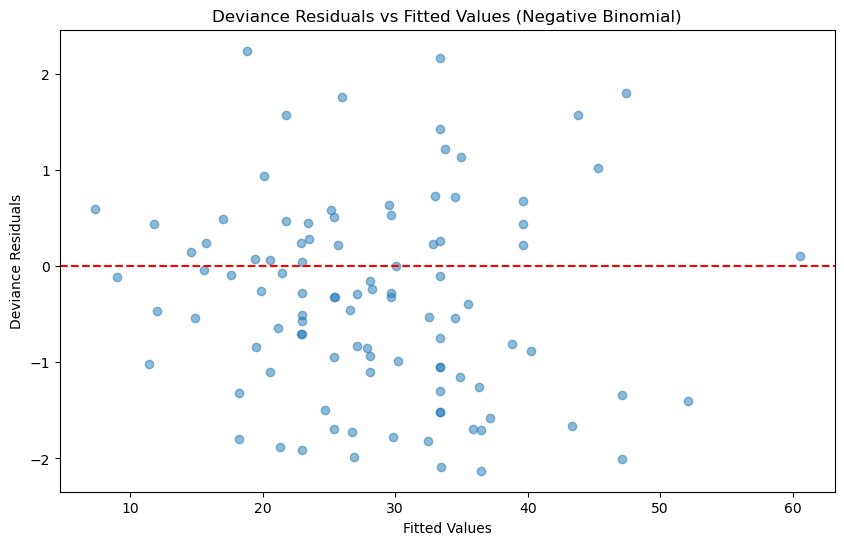

In [36]:
# Extract deviance residuals and fitted values
deviance_residuals4 = model_NegBin4.resid_deviance
fitted_values4 = model_NegBin4.fittedvalues

# Plot residuals vs fitted values
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values4, deviance_residuals4, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Deviance Residuals vs Fitted Values (Negative Binomial)')
plt.xlabel('Fitted Values')
plt.ylabel('Deviance Residuals')
plt.show()

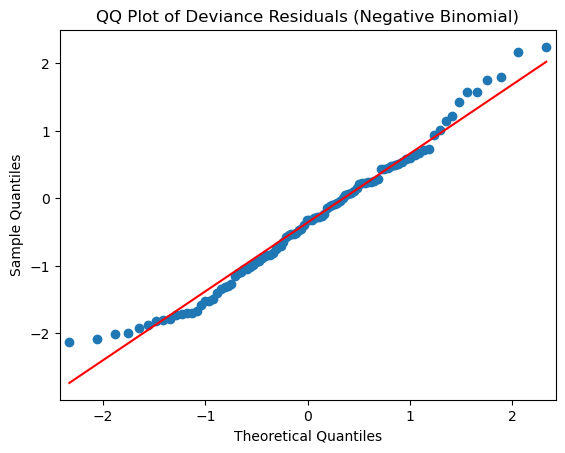

In [37]:
# QQ plot for deviance residuals
sm.qqplot(deviance_residuals4, line='s')
plt.title('QQ Plot of Deviance Residuals (Negative Binomial)')
plt.show()

In [38]:
# Poisson regression model 2
model_Poisson4 = sm.GLM(Y4, X4, family=sm.families.Poisson()).fit()

# Print the summary of the Poisson model
print(model_Poisson4.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             titles_won   No. Observations:                  100
Model:                            GLM   Df Residuals:                       91
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1693.3
Date:                Thu, 05 Jun 2025   Deviance:                       2934.8
Time:                        12:16:47   Pearson chi2:                 3.46e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9843
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.4095      0.10

In [39]:
# Print out the AIC and BIC for the Poisson and NB models
print(f"Poisson Model AIC: {model_Poisson4.aic}, BIC: {model_Poisson4.bic}")
print(f"Negative Binomial Model AIC: {model_NegBin4.aic}, BIC: {model_NegBin4.bic}")

Poisson Model AIC: 3404.631039070547, BIC: 2515.733613178752
Negative Binomial Model AIC: 879.5219284629776, BIC: -302.2859947601462


c:\Users\peta_\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


### Model 5: Titles ~ Mother ISEI, Father ISEI, Sibling Info, Association Dummies, Country Dummies

In [40]:
# Define predictors for Model 5
predictors5 = ['mother_ISEI', 'father_ISEI', 'sibling_info', 'association_WTA'] + [f'country_{c.replace(" ", "_")}' for c in top_countries]

# Check multicollinearity using Variance Inflation Factor (VIF)
X5_vif = df[predictors5]
vif_data5 = pd.DataFrame({
    'Variable': X5_vif.columns,
    'VIF': [variance_inflation_factor(X5_vif.values, i)
            for i in range(X5_vif.shape[1])]
})
print("VIF with both ISEI scores:\n", vif_data5)

VIF with both ISEI scores:
             Variable       VIF
0        mother_ISEI  9.844285
1        father_ISEI  9.769509
2       sibling_info  8.490527
3    association_WTA  1.796871
4        country_USA  1.560187
5     country_Russia  1.164586
6  country_Australia  1.136073
7     country_France  1.141784
8      country_Spain  1.128897


In [41]:
# Compute correlation between mother and father ISEI
correlation_mother_father = df['mother_ISEI'].corr(df['father_ISEI'])
print(f"Correlation between mother ISEI and father ISEI: {correlation_mother_father:.2f}")

Correlation between mother ISEI and father ISEI: 0.17


In [42]:
# Prepare regression matrices for Model 5
Y5 = df['titles_won']
X5 = sm.add_constant(df[predictors5])

# Fit Negative Binomial regression model for Model 5
model_NegBin5 = sm.GLM(Y5, X5, family=NegativeBinomial()).fit()

# Print the summary of the Negative Binomial model for Model 5
print(model_NegBin5.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             titles_won   No. Observations:                  100
Model:                            GLM   Df Residuals:                       90
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -427.96
Date:                Thu, 05 Jun 2025   Deviance:                       111.19
Time:                        12:16:47   Pearson chi2:                     117.
No. Iterations:                    12   Pseudo R-squ. (CS):             0.1693
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.1713      0.54

c:\Users\peta_\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [43]:
# Check empirical dispersion from Negative Binomial model 5
dispersion5 = model_NegBin5.deviance / model_NegBin5.df_resid
print(f"Empirical Dispersion: {dispersion5:.2f}")

Empirical Dispersion: 1.24


In [44]:
# Calculate the "true" dispersion parameter for Model 5
nb2 = CountNB(Y5, X5).fit(disp=False, maxiter=100, method='newton')

print("Converged:", nb2.mle_retvals['converged'])
print("Alpha estimate:", nb2.params['alpha'])

Converged: True
Alpha estimate: 0.9912492068676463


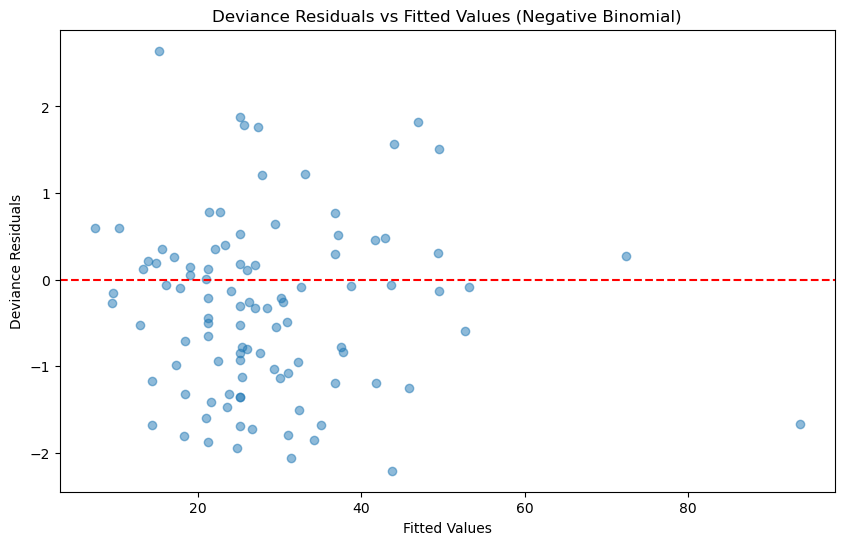

In [45]:
# Extract deviance residuals and fitted values
deviance_residuals5 = model_NegBin5.resid_deviance
fitted_values5 = model_NegBin5.fittedvalues

# Plot residuals vs fitted values
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values5, deviance_residuals5, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Deviance Residuals vs Fitted Values (Negative Binomial)')
plt.xlabel('Fitted Values')
plt.ylabel('Deviance Residuals')
plt.show()

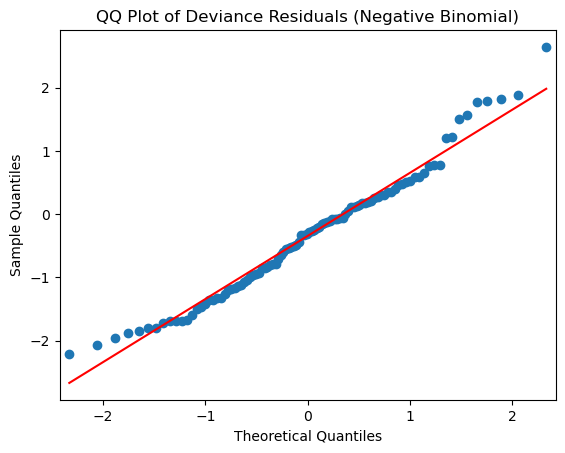

In [46]:
# QQ plot for deviance residuals
sm.qqplot(deviance_residuals5, line='s')
plt.title('QQ Plot of Deviance Residuals (Negative Binomial)')
plt.show()

In [47]:
# Poisson regression model 5
model_Poisson5 = sm.GLM(Y5, X5, family=sm.families.Poisson()).fit()

# Print the summary of the Poisson model
print(model_Poisson5.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             titles_won   No. Observations:                  100
Model:                            GLM   Df Residuals:                       90
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1607.7
Date:                Thu, 05 Jun 2025   Deviance:                       2763.7
Time:                        12:16:47   Pearson chi2:                 3.33e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9972
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.1478      0.09

In [48]:
# Print out the AIC and BIC for the Poisson and NB models
print(f"Poisson Model AIC: {model_Poisson5.aic}, BIC: {model_Poisson5.bic}")
print(f"Negative Binomial Model AIC: {model_NegBin5.aic}, BIC: {model_NegBin5.bic}")

Poisson Model AIC: 3235.482475719535, BIC: 2349.190220013728
Negative Binomial Model AIC: 875.9295887290303, BIC: -303.2731643081065


c:\Users\peta_\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


### Model 6: Titles ~ Mother ISEI, Father ISEI, Sibling Player, Association Dummies, Country Dummies

In [49]:
# Define predictors for Model 6
predictors6 = ['mother_ISEI', 'father_ISEI', 'sibling_player', 'association_WTA'] + [f'country_{c.replace(" ", "_")}' for c in top_countries]

# Check multicollinearity using Variance Inflation Factor (VIF)
X6_vif = df[predictors6]
vif_data6 = pd.DataFrame({
    'Variable': X6_vif.columns,
    'VIF': [variance_inflation_factor(X6_vif.values, i)
            for i in range(X6_vif.shape[1])]
})
print("VIF with both ISEI scores:\n", vif_data6)

VIF with both ISEI scores:
             Variable       VIF
0        mother_ISEI  8.001378
1        father_ISEI  9.044876
2     sibling_player  2.088483
3    association_WTA  1.782228
4        country_USA  1.555802
5     country_Russia  1.162107
6  country_Australia  1.107363
7     country_France  1.106788
8      country_Spain  1.136090


In [50]:
# Prepare regression matrices for Model 6
Y6 = df['titles_won']
X6 = sm.add_constant(df[predictors6])

# Fit Negative Binomial regression model for Model 6
model_NegBin6 = sm.GLM(Y6, X6, family=NegativeBinomial()).fit()

# Print the summary of the Negative Binomial model for Model 6
print(model_NegBin6.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             titles_won   No. Observations:                  100
Model:                            GLM   Df Residuals:                       90
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -429.81
Date:                Thu, 05 Jun 2025   Deviance:                       114.88
Time:                        12:16:47   Pearson chi2:                     123.
No. Iterations:                    12   Pseudo R-squ. (CS):             0.1381
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.8317      0.49

c:\Users\peta_\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [51]:
# Mean center the mother and father ISEI variables
df['mother_ISEI_c'] = df['mother_ISEI'] - df['mother_ISEI'].mean()
df['father_ISEI_c'] = df['father_ISEI'] - df['father_ISEI'].mean()

In [52]:
# Create interaction term between mother ISEI and sibling info
df['mother_ISEI_x_sibling_info'] = df['mother_ISEI_c'] * df['sibling_info']

### Model 7: Titles ~ Mother ISEI, Father ISEI, Sibling Info, Mother ISEIxSibling Info interaction, Association Dummies, Country Dummies

In [53]:
# Define predictors for Model 7
predictors7 = ['mother_ISEI_c', 'father_ISEI_c', 'mother_ISEI_x_sibling_info', 'sibling_info', 'association_WTA'] + [f'country_{c.replace(" ", "_")}' for c in top_countries]

# Check multicollinearity using Variance Inflation Factor (VIF)
X7_vif = df[predictors7]
vif_data7 = pd.DataFrame({
    'Variable': X7_vif.columns,
    'VIF': [variance_inflation_factor(X7_vif.values, i)
            for i in range(X7_vif.shape[1])]
})
print("VIF with both ISEI scores and interaction between mother ISEI and sibling info:\n", vif_data7)

VIF with both ISEI scores and interaction between mother ISEI and sibling info:
                      Variable       VIF
0               mother_ISEI_c  8.785631
1               father_ISEI_c  1.072106
2  mother_ISEI_x_sibling_info  8.659004
3                sibling_info  2.821499
4             association_WTA  1.759568
5                 country_USA  1.541589
6              country_Russia  1.155217
7           country_Australia  1.137258
8              country_France  1.147338
9               country_Spain  1.130541


In [54]:
# Prepare regression matrices for Model 7
Y7 = df['titles_won']
X7 = sm.add_constant(df[predictors7])

# Fit Negative Binomial regression model for Model 7
model_NegBin7 = sm.GLM(Y7, X7, family=NegativeBinomial()).fit()
# Print the summary of the Negative Binomial model for Model 7
print(model_NegBin7.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             titles_won   No. Observations:                  100
Model:                            GLM   Df Residuals:                       89
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -427.40
Date:                Thu, 05 Jun 2025   Deviance:                       110.06
Time:                        12:16:48   Pearson chi2:                     115.
No. Iterations:                    16   Pseudo R-squ. (CS):             0.1787
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

c:\Users\peta_\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [55]:
# Print out the AIC and BIC for Model 5 and Model 7
print(f"Negative Binomial Model 5 AIC: {model_NegBin5.aic}, BIC: {model_NegBin5.bic}")
print(f"Negative Binomial Model 7 AIC: {model_NegBin7.aic}, BIC: {model_NegBin7.bic}")

Negative Binomial Model 5 AIC: 875.9295887290303, BIC: -303.2731643081065
Negative Binomial Model 7 AIC: 876.7981053668075, BIC: -299.7994774843406


c:\Users\peta_\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


In [56]:
df['mother_ISEI_x_association_WTA'] = df['mother_ISEI_c'] * df['association_WTA']

### Model 8: Titles ~ Mother ISEI, Father ISEI, Sibling Info, Mother ISEIxAssociation, Association Dummies, Country Dummies

In [57]:
# Define predictors for Model 8
predictors8 = ['mother_ISEI_c', 'father_ISEI_c', 'mother_ISEI_x_association_WTA', 'sibling_info', 'association_WTA'] + [f'country_{c.replace(" ", "_")}' for c in top_countries]

# Check multicollinearity using Variance Inflation Factor (VIF)
X8_vif = df[predictors8]
vif_data8 = pd.DataFrame({
    'Variable': X8_vif.columns,
    'VIF': [variance_inflation_factor(X8_vif.values, i)
            for i in range(X8_vif.shape[1])]
})
print("VIF with both ISEI scores and interaction between mother ISEI and association:\n", vif_data8)

VIF with both ISEI scores and interaction between mother ISEI and association:
                         Variable       VIF
0                  mother_ISEI_c  2.050345
1                  father_ISEI_c  1.098435
2  mother_ISEI_x_association_WTA  2.025252
3                   sibling_info  2.802687
4                association_WTA  1.700099
5                    country_USA  1.538970
6                 country_Russia  1.150883
7              country_Australia  1.138249
8                 country_France  1.201956
9                  country_Spain  1.154996


In [58]:
# Prepare regression matrices for Model 8
Y8 = df['titles_won']
X8 = sm.add_constant(df[predictors8])

# Fit Negative Binomial regression model for Model 8
model_NegBin8 = sm.GLM(Y8, X8, family=NegativeBinomial()).fit()

# Print the summary of the Negative Binomial model for Model 8
print(model_NegBin8.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             titles_won   No. Observations:                  100
Model:                            GLM   Df Residuals:                       89
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -427.43
Date:                Thu, 05 Jun 2025   Deviance:                       110.13
Time:                        12:16:48   Pearson chi2:                     110.
No. Iterations:                    13   Pseudo R-squ. (CS):             0.1781
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

c:\Users\peta_\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [59]:
# Print out the AIC and BIC for Model 5 and Model 8
print(f"Negative Binomial Model 5 AIC: {model_NegBin5.aic}, BIC: {model_NegBin5.bic}")
print(f"Negative Binomial Model 8 AIC: {model_NegBin8.aic}, BIC: {model_NegBin8.bic}")

Negative Binomial Model 5 AIC: 875.9295887290303, BIC: -303.2731643081065
Negative Binomial Model 8 AIC: 876.8644779997423, BIC: -299.7331048514053


c:\Users\peta_\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


In [60]:
df['mother_ISEI_x_father_ISEI'] = df['mother_ISEI_c'] * df['father_ISEI_c']

### Model 9: Titles ~ Mother ISEI, Father ISEI, Sibling Info, Mother ISEIxFather ISEI interaction, Association Dummies, Country Dummies

In [61]:
# Define predictors for Model 9
predictors9 = ['mother_ISEI_c', 'father_ISEI_c', 'mother_ISEI_x_father_ISEI', 'sibling_info', 'association_WTA'] + [f'country_{c.replace(" ", "_")}' for c in top_countries]

# Check multicollinearity using Variance Inflation Factor (VIF)
X9_vif = df[predictors9]
vif_data9 = pd.DataFrame({
    'Variable': X9_vif.columns,
    'VIF': [variance_inflation_factor(X9_vif.values, i)
            for i in range(X9_vif.shape[1])]
})
print("VIF with both ISEI scores and interaction between mother ISEI and father ISEI:\n", vif_data9)

VIF with both ISEI scores and interaction between mother ISEI and father ISEI:
                     Variable       VIF
0              mother_ISEI_c  1.230526
1              father_ISEI_c  1.160891
2  mother_ISEI_x_father_ISEI  1.487720
3               sibling_info  2.793415
4            association_WTA  1.782659
5                country_USA  1.573861
6             country_Russia  1.208312
7          country_Australia  1.163367
8             country_France  1.164210
9              country_Spain  1.134411


In [62]:
# Prepare regression matrices for Model 9
Y9 = df['titles_won']
X9 = sm.add_constant(df[predictors9])

# Fit Negative Binomial regression model for Model 9
model_NegBin9 = sm.GLM(Y9, X9, family=NegativeBinomial()).fit()

# Print the summary of the Negative Binomial model for Model 9
print(model_NegBin9.summary())

c:\Users\peta_\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:             titles_won   No. Observations:                  100
Model:                            GLM   Df Residuals:                       89
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -427.90
Date:                Thu, 05 Jun 2025   Deviance:                       111.07
Time:                        12:16:48   Pearson chi2:                     115.
No. Iterations:                    16   Pseudo R-squ. (CS):             0.1703
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [63]:
# Print out the AIC and BIC for Model 5 and Model 9
print(f"Negative Binomial Model 5 AIC: {model_NegBin5.aic}, BIC: {model_NegBin5.bic}")
print(f"Negative Binomial Model 9 AIC: {model_NegBin9.aic}, BIC: {model_NegBin9.bic}")

Negative Binomial Model 5 AIC: 875.9295887290303, BIC: -303.2731643081065
Negative Binomial Model 9 AIC: 877.8062373067792, BIC: -298.79134554436826


c:\Users\peta_\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


In [64]:
df['mother_ISEI_x_country_USA'] = df['mother_ISEI_c'] * df['country_USA']

### Model 10: Titles ~ Mother ISEI, Father ISEI, Sibling Info, Mother ISEIxCountry USA interaction, Association Dummies, Country Dummies

In [65]:
# Define predictors for Model 10
predictors10 = ['mother_ISEI_c', 'father_ISEI_c', 'mother_ISEI_x_country_USA', 'sibling_info', 'association_WTA'] + [f'country_{c.replace(" ", "_")}' for c in top_countries]

# Check multicollinearity using Variance Inflation Factor (VIF)
X10_vif = df[predictors10]
vif_data10 = pd.DataFrame({
    'Variable': X10_vif.columns,
    'VIF': [variance_inflation_factor(X10_vif.values, i)
            for i in range(X10_vif.shape[1])]
})
print("VIF with both ISEI scores and interaction between mother ISEI and USA:\n", vif_data10)

VIF with both ISEI scores and interaction between mother ISEI and USA:
                     Variable       VIF
0              mother_ISEI_c  1.303119
1              father_ISEI_c  1.158684
2  mother_ISEI_x_country_USA  1.434814
3               sibling_info  2.790477
4            association_WTA  1.701042
5                country_USA  1.613606
6             country_Russia  1.149810
7          country_Australia  1.137023
8             country_France  1.150141
9              country_Spain  1.130040


In [66]:
# Prepare regression matrices for Model 10
Y10 = df['titles_won']
X10 = sm.add_constant(df[predictors10])

# Fit Negative Binomial regression model for Model 10
model_NegBin10 = sm.GLM(Y10, X10, family=NegativeBinomial()).fit()

# Print the summary of the Negative Binomial model for Model 10
print(model_NegBin10.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             titles_won   No. Observations:                  100
Model:                            GLM   Df Residuals:                       89
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -426.24
Date:                Thu, 05 Jun 2025   Deviance:                       107.74
Time:                        12:16:48   Pearson chi2:                     115.
No. Iterations:                    15   Pseudo R-squ. (CS):             0.1975
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

c:\Users\peta_\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [67]:
# Print out the AIC and BIC for Model 5 and Model 10
print(f"Negative Binomial Model 5 AIC: {model_NegBin5.aic}, BIC: {model_NegBin5.bic}")
print(f"Negative Binomial Model 10 AIC: {model_NegBin10.aic}, BIC: {model_NegBin10.bic}")

Negative Binomial Model 5 AIC: 875.9295887290303, BIC: -303.2731643081065
Negative Binomial Model 10 AIC: 874.4743930229105, BIC: -302.1231898282382


c:\Users\peta_\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
